In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm

from eofs.xarray import Eof
from scipy import stats
from scipy.signal import detrend
from sklearn.utils import resample
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

In [2]:
data_path = ('/mnt/nas153/Roshan/PhD_Project_3/ERA5_UVTH/')
uwind =[]
for year in range(1973, 2023):
    print(year)
    file_path = os.path.join(data_path,f'{year}_UVTH.nc')
    u = xr.open_dataset(file_path)
    u200=u.sel(level=200)
    uwnd = u200.resample(time='D').mean()
    uwind.append(uwnd)
    
uwind_ds = xr.concat(uwind,dim='time')
uwind_ds['dayofyear'] = uwind_ds['time.dayofyear']
leap_years = (uwind_ds['time.year'] % 4 == 0) & ((uwind_ds['time.year'] % 100 != 0) | (uwind_ds['time.year'] % 400 == 0))
uwind_ds['dayofyear'] = xr.where(leap_years & (uwind_ds['time.month'] > 2),
                                               uwind_ds['dayofyear'] - 1,
                                               uwind_ds['dayofyear'])   

1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [3]:
UVTH_200_Ano = uwind_ds.groupby('dayofyear') - uwind_ds.groupby('dayofyear').mean(dim='time')
Uwind_200_Ano_SS = UVTH_200_Ano.u.sel(latitude=slice(50,20), longitude=slice(40,90))
Uwind_200_Ano_SS = Uwind_200_Ano_SS.drop_vars(['dayofyear'])

In [4]:

data1 = xr.Dataset({"u": (('time','lat','lon'), Uwind_200_Ano_SS.values)},
                           coords={'time':Uwind_200_Ano_SS.time.values,'lat': Uwind_200_Ano_SS.latitude.values, 'lon': Uwind_200_Ano_SS.longitude.values})

coslat = np.cos(np.deg2rad(data1.u.lat.values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]

solver = Eof(data1['u'],weights=wgts)

eofs = solver.eofs(neofs=3)
pcs = solver.pcs(npcs=3, pcscaling=1)
eofs=eofs*-1
pcs=pcs*-1

var_frac = solver.varianceFraction(neigs=3)*100

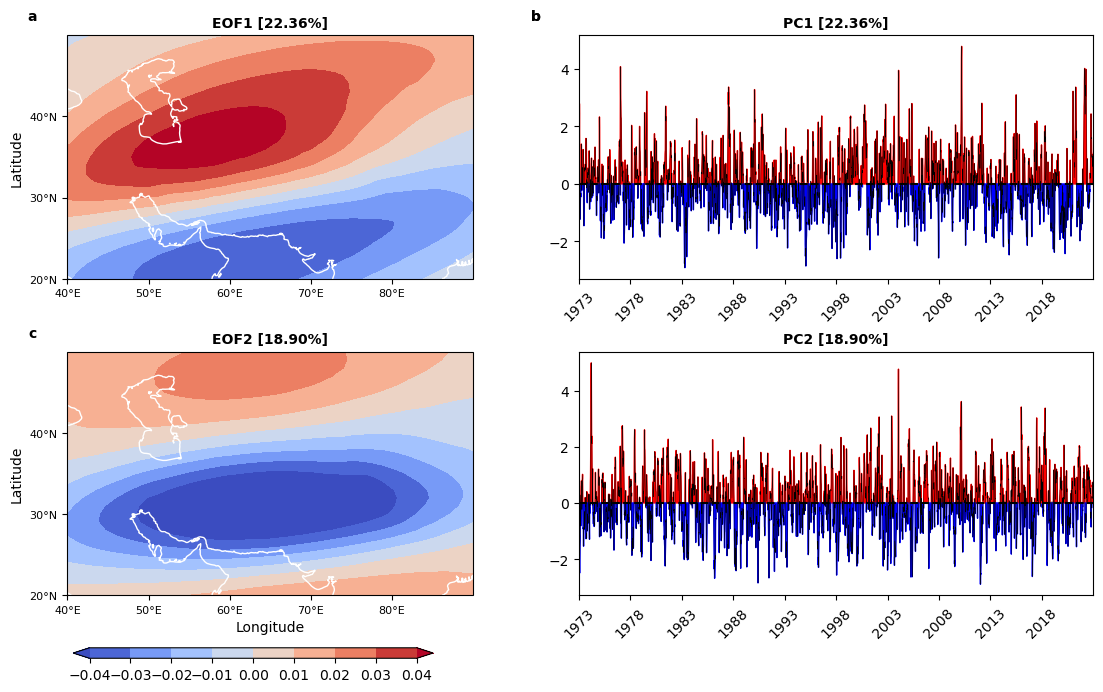

In [5]:
fig = plt.figure(figsize=(12,7))

clev=np.arange(-0.04,0.041,0.01)
ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), fig=fig, projection=ccrs.PlateCarree())

cf_plot = ax1.contourf(eofs.lon, eofs.lat, eofs.sel(mode=0),clev,transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')

ax1.add_feature(cfeature.COASTLINE, edgecolor='white')

ax1.set_xticks(np.arange(40,90,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)

ax1.set_yticks(np.arange(20,50,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax1.tick_params(axis='both', which='major', labelsize=8)

#ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
vf = var_frac.sel(mode=0).values
ax1.set_title(f'EOF1 [{vf:.2f}%]', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax1.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

####

ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), fig=fig, projection=ccrs.PlateCarree())

cf_plot = ax2.contourf(eofs.lon, eofs.lat, eofs.sel(mode=1),clev,transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')

ax2.add_feature(cfeature.COASTLINE, edgecolor='white')

ax2.set_xticks(np.arange(40,90,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)

ax2.set_yticks(np.arange(20,50,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax2.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax2.tick_params(axis='both', which='major', labelsize=8)

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
 
vf = var_frac.sel(mode=1).values
ax2.set_title(f'EOF2 [{vf:.2f}%]', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax2.text(-0.075, 1.05, 'c',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')

###

ax3 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), fig=fig)

year_ticks = range(1, 4601, 92*5)  
year_labels = range(1973, 2023, 5)  
pc1 = pcs.sel(mode=0)
ax3.plot(range(1, 4601), pc1.values, linewidth=0.3, color='black')  
ax3.fill_between(range(1, 4601), pc1.values, color='red', where=(pc1 >= 0)) 
ax3.fill_between(range(1, 4601), pc1.values, color='blue', where=(pc1 < 0))  
ax3.set_xticks(year_ticks)
ax3.set_xticklabels(year_labels, rotation=45) 
ax3.set_xlim(1, 4600)  # Changed to set_xlim
ax3.axhline(0, color='k', linestyle='--')
vf = var_frac.sel(mode=0).values
ax3.set_title(f'PC1 [{vf:.2f}%]', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax3.text(-0.075, 1.05, 'b', verticalalignment='bottom', horizontalalignment='right', transform=ax3.transAxes, color='k', weight='bold')

###
ax4 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), fig=fig)

year_ticks = range(1, 4601, 92*5)  
year_labels = range(1973, 2023, 5)  
pc1 = pcs.sel(mode=1)
ax4.plot(range(1, 4601), pc1.values, linewidth=0.3, color='black')  
ax4.fill_between(range(1, 4601), pc1.values, color='red', where=(pc1 >= 0)) 
ax4.fill_between(range(1, 4601), pc1.values, color='blue', where=(pc1 < 0))  
ax4.set_xticks(year_ticks)
ax4.set_xticklabels(year_labels, rotation=45) 
ax4.set_xlim(1, 4600)  # Changed to set_xlim
ax4.axhline(0, color='k', linestyle='--')
vf = var_frac.sel(mode=1).values
ax4.set_title(f'PC2 [{vf:.2f}%]', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax4.text(-0.075, 1.05, 'b', verticalalignment='bottom', horizontalalignment='right', transform=ax3.transAxes, color='k', weight='bold')

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.3)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.1, 0.01, 0.3, 0.015])

# Draw the colorbar
cbar=fig.colorbar(cf_plot, cax=cbar_ax,orientation='horizontal')

plt.savefig('SFigure_6.png', dpi=600,bbox_inches='tight')
plt.savefig('SFigure_6.pdf', dpi=600,bbox_inches='tight')

In [6]:
pc1 = pcs.sel(mode=0)

PC1_South = pc1.where(pc1 < 0.5, drop=True)
PC1_North = pc1.where(pc1 > 0.5, drop=True)

R1_hot_days = PC1_North.sel(time=slice('1973','1997'))
R2_hot_days = PC1_North.sel(time=slice('1998','2022'))

In [7]:
years = np.arange(1973, 2023)

freq = np.zeros([np.size(years)]) 
persis = np.zeros([np.size(years)])

for yr, year in enumerate(range(1973, 2023)):
    PC1_year = PC1_North.sel(time=f'{year}')
    if PC1_year.size == 0:
        freq[yr] = 0
        persis[yr] = 0
    else:
        df_hd = PC1_year.to_dataframe()
        df_hd['group'] = (df_hd.index.to_series().diff() != pd.Timedelta(days=1)).cumsum()
        grouped = df_hd.groupby('group')
        dataframes_list = [group.drop(columns='group') for _, group in grouped]
        freq[yr]= sum(len(df) for df in dataframes_list)
        persis[yr] = max(len(df) for df in dataframes_list)  # HWD: Length of the dataframe with maximum values
        
PC1_Aspect = xr.Dataset({"Freq": (('year'), freq),
                           "Persist": (('year'), persis)},
                           coords={'year':years})    

In [8]:
from pyhomogeneity import pettitt_test
cp_test_res = pettitt_test(freq)

In [9]:
cp_test_res

Pettitt_Test(h=False, cp=25, p=0.2579, U=192.0, avg=mean(mu1=22.68, mu2=29.92))

In [10]:
data_path = ('/mnt/nas153/Roshan/ERA5_DATA/ERA5_T2/')
t2m_max =[]
for year in range(1973, 2023):
    print(year)
    file_path = os.path.join(data_path,f'T2_hourly-{year}-1deg.nc')
    t2m = xr.open_dataset(file_path)    
    temp_max = t2m.resample(time='D').max()
    t2m_max.append(temp_max)

1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [11]:
ds = xr.concat(t2m_max,dim='time')
lsm= xr.open_dataset('land_sea_mask.nc')
mask = lsm.lsm.values
ds = ds.where(mask != 0, float('nan'))
Tmax = ds - 273.15
Tmax = Tmax.where(~((Tmax['time.month'] == 2) & (Tmax['time.day'] == 29)), drop=True)
Tmax_MAM = Tmax.sel(time=Tmax['time.season'] == 'MAM')

Tmax_MAM['dayofyear'] = Tmax_MAM['time.dayofyear']
leap_years = (Tmax_MAM['time.year'] % 4 == 0) & ((Tmax_MAM['time.year'] % 100 != 0) | (Tmax_MAM['time.year'] % 400 == 0))
Tmax_MAM['dayofyear'] = xr.where(leap_years & (Tmax_MAM['time.month'] > 2),
                                               Tmax_MAM['dayofyear'] - 1,
                                               Tmax_MAM['dayofyear'])
Tmax_MAM_Ano = Tmax_MAM.groupby('dayofyear') - Tmax_MAM.groupby('dayofyear').mean(dim='time')

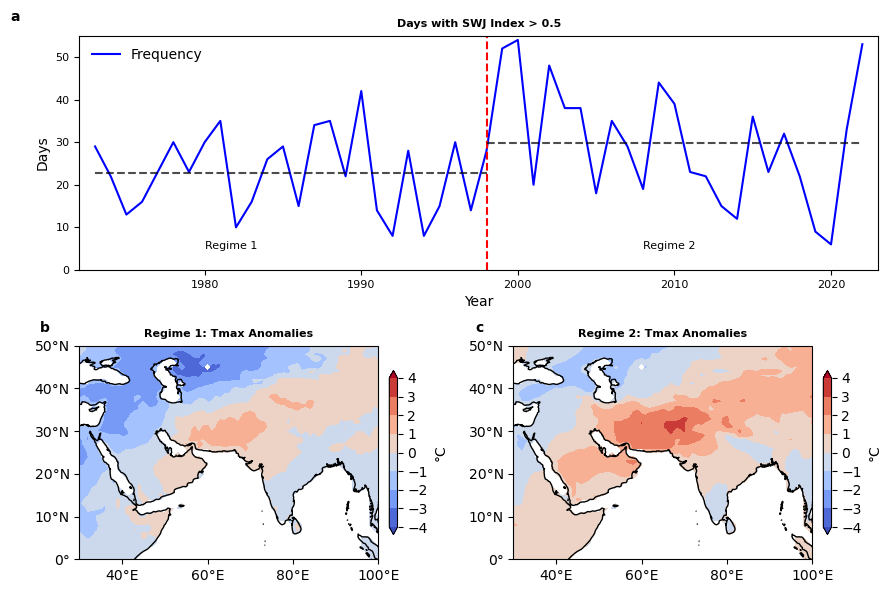

In [12]:
pc1_mu1 = PC1_Aspect.Freq.sel(year=slice('1973','1997')).mean(dim='year')
pc1_mu2 = PC1_Aspect.Freq.sel(year=slice('1998','2022')).mean(dim='year')
R1_Tmax_Ano = Tmax_MAM_Ano.t2m.sel(time=R1_hot_days.time.values).mean(dim='time')
R2_Tmax_Ano = Tmax_MAM_Ano.t2m.sel(time=R2_hot_days.time.values).mean(dim='time')

fig = plt.figure(figsize=(9,6))
ax2= plt.subplot2grid(shape=(2,2), loc=(0, 0), colspan=2, fig=fig)
ax2.plot(PC1_Aspect.year, PC1_Aspect.Freq,label="Frequency",color='blue')
ax2.axvline(x=years[25], color='r', linestyle='--')

ax2.plot([1973, years[25]], [pc1_mu1, pc1_mu1], color='k', linestyle='--',alpha=0.7) #, label=f'Regime 1 Mean: {mu1_imd}')
ax2.plot([years[25],2022], [pc1_mu2, pc1_mu2], color='k', linestyle='--',alpha=0.7) #, label=f'Regime 2 Mean: {mu2_imd}')
ax2.set_xlim(1972,2023)
ax2.set_ylim(0,55)

ax2.text(1980, 5, "Regime 1", fontsize=8)
ax2.text(2008, 5, "Regime 2", fontsize=8)
ax2.legend(loc='upper left',frameon=False, ncol=1)
ax2.set_ylabel('Days', fontsize=10)
ax2.set_xlabel('Year', fontsize=10)
ax2.tick_params(axis='both', which='major', labelsize=8)

ax2.set_title('Days with SWJ Index > 0.5',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax2.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')

###

ax1 = plt.subplot2grid(shape=(2,2), loc=(1, 0), colspan=1, fig=fig, projection=ccrs.PlateCarree())
clevs=np.arange(-4,5,1)
cf_plot = ax1.contourf(R1_Tmax_Ano.longitude, R1_Tmax_Ano.latitude, R1_Tmax_Ano,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.7)
cbar.set_label('°C')
ax1.coastlines()
ax1.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_extent([30, 100, 0, 50],crs=ccrs.PlateCarree())
ax1.set_title('Regime 1: Tmax Anomalies',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax1.text(-0.1, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

####

ax3 = plt.subplot2grid(shape=(2,2), loc=(1, 1), colspan=1, fig=fig, projection=ccrs.PlateCarree())
cf_plot = ax3.contourf(R2_Tmax_Ano.longitude, R2_Tmax_Ano.latitude, R2_Tmax_Ano,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.7)
cbar.set_label('°C')
ax3.coastlines()
ax3.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_extent([30, 100, 0, 50],crs=ccrs.PlateCarree())
ax3.set_title('Regime 2: Tmax Anomalies',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax3.text(-0.1, 1.05, 'c',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,color='k', weight='bold')

######
plt.tight_layout()

plt.savefig('SFigure_7.png', dpi=600,bbox_inches='tight')
plt.savefig('SFigure_7.pdf', dpi=600,bbox_inches='tight')